# Polarization Splitter Rotator

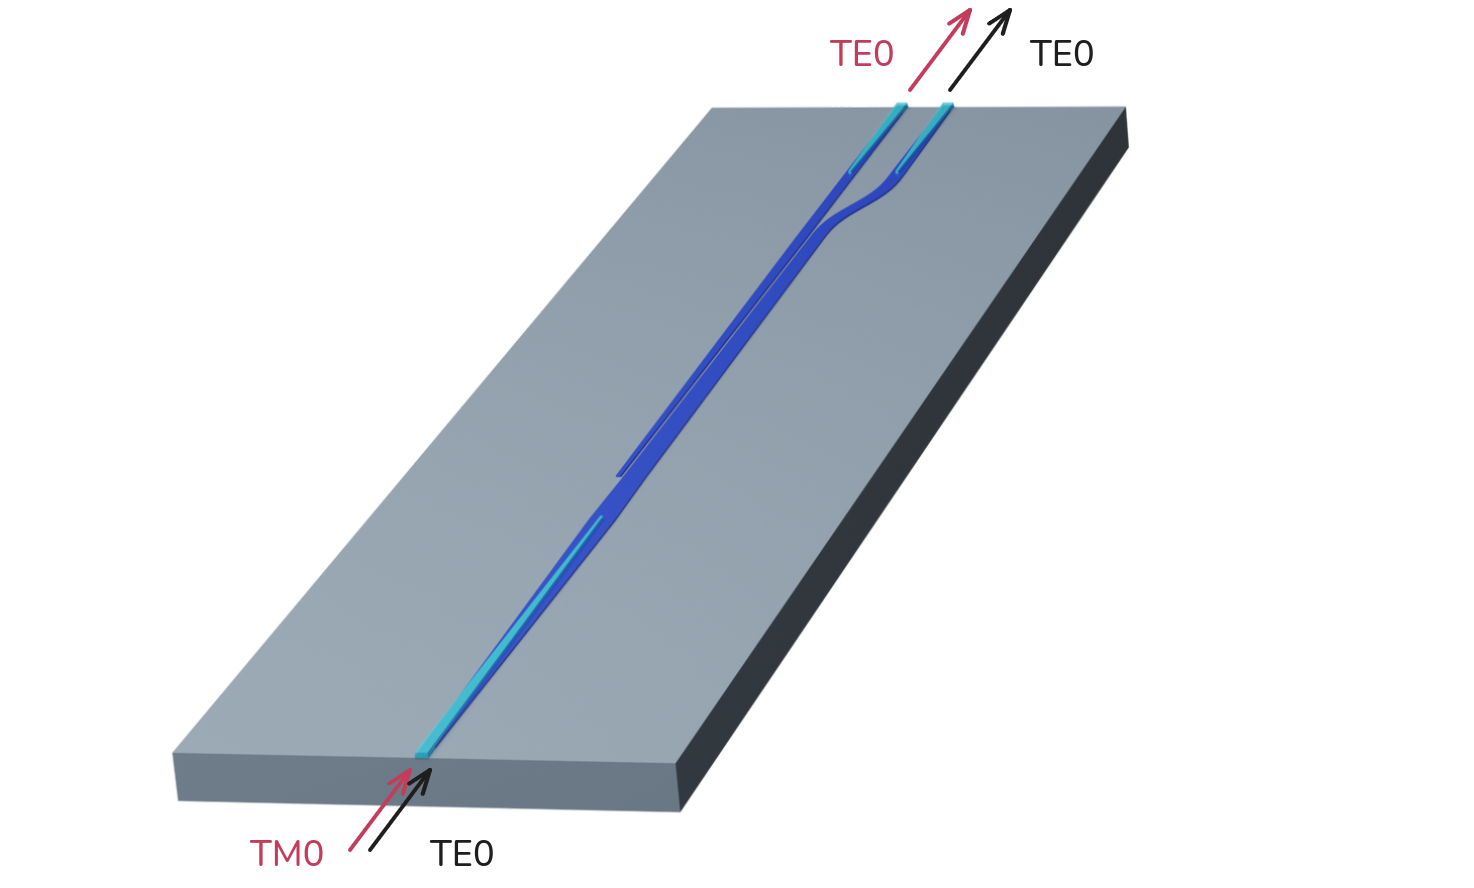

A polarization splitter rotator (PSR) is a fundamental building block for most photonics platforms that converts between 2 orthogonal polarizations in a single waveguide (TE₀ and TM₀) into the fundamental mode (TE₀) of 2 separate waveguides.
Coherent devices, such as an IQ modulator, rely on PSR for polarization multiplexing.

In this example, we will design and optimize a PSR based on the proposal by \[1] for a different photonics platform.
The PSR in this proposal consists of two sections:
- the rotator section, designed to rotate the TM₀ mode to the TE₁, and
- the asymmetric directional coupler, designed to spatially couple the TE₁ mode of one waveguide to the TE₀ of another. 

We will be using the [SiEPIC OpenEBL](https://siepic.ca/openebl/) photonics platform, which is different from the original reference.
For that reason, the PSR will be redesigned and re-optimized.

**References**

1. Tian, Y.; Kang, Z.; Dai, T.; Xu, P.; Li, Y.; Lv, Y.; Zhang, X. "Broadband Polarization Rotator and Splitter Based on 70 nm-Etched Waveguides on SOI Platform." *Photonics* 2022, 9, 758, doi: [10.3390/photonics9100758](https://doi.org/10.3390/photonics9100758).

In [1]:
import numpy as np
import scipy.optimize
import tidy3d as td
import photonforge as pf
import siepic_forge as siepic
from matplotlib import pyplot as plt

The first step is to configure the default [technology](../_autosummary/photonforge.Technology.rst) for our project.

In [2]:
tech = siepic.ebeam()
pf.config.default_technology = tech

## Initial PSR

We will create the complete PSR as a [parametric component](../guides/Custom_Parametric_Components.ipynb) using the dimensions from \[1] as a starting point.

The TE and TM ports available as defaults in SiEPIC's technology are:

In [3]:
pf.config.default_technology.ports["TM_1550_500"]

PortSpec(description="Strip TM 1550 nm, w=500 nm", width=2.5, limits=(-1, 1.22), num_modes=2, polarization="", target_neff=3.5, path_profiles={(0.5, 0, (1, 0))})

In [4]:
pf.config.default_technology.ports["TE_1550_500"]

PortSpec(description="Strip TE 1550 nm, w=500 nm", width=2, limits=(-1, 1.22), num_modes=1, polarization="", target_neff=3.5, path_profiles={(0.5, 0, (1, 0))})

From their path profiles and widths we can define the fixed parameters of our design:

In [5]:
core_width = 0.5  # input/output port core width
output_separation = 1.5  # separation between TE ports at the split output

Although complex, the PSR geometry can be easily created using [paths](../_autosummary/photonforge.Path.rst) in PhotonForge.
We also add the appropriate ports and model to the resulting component, making sure our function allows us to fine-tune the model with `model_kwargs`.

In [6]:
@pf.parametric_component
def create_psr(
    *,
    rotator_length=70,
    mid_taper_length=5,
    splitter_length=100,
    taper_length=10,
    rotator_width=1.1,
    taper_width=0.1,
    coupler_width1=0.95,
    coupler_width2=0.65,
    splitter_width1=0.2,
    gap=0.15,
    s_factor=6,
    model_kwargs={},
):
    component = pf.Component()

    s_bend_length = s_factor * output_separation
    splitter_width2 = coupler_width1 + splitter_width1 - coupler_width2
    if splitter_width2 <= 0:
        raise ValueError("Invalid input")

    p0 = (0, 0)
    p1 = (
        rotator_length + mid_taper_length + splitter_length + s_bend_length + taper_length,
        -output_separation,
    )
    p2 = (
        rotator_length + mid_taper_length + splitter_length + s_bend_length + taper_length,
        gap + 0.5 * (coupler_width2 + splitter_width2),
    )
    tapers = [
        pf.Path(p0, core_width).segment((rotator_length, 0), taper_width),
        pf.Path(p1, core_width).segment((-taper_length, 0), taper_width, relative=True),
        pf.Path(p2, core_width).segment((-taper_length, 0), taper_width, relative=True),
    ]

    main_path = (
        pf.Path((0, 0), core_width)
        .segment((rotator_length, 0), rotator_width)
        .segment((mid_taper_length, 0), coupler_width1, relative=True)
        .segment((splitter_length, 0), coupler_width2, relative=True)
        .s_bend((s_bend_length, -output_separation), euler_fraction=0.5, relative=True)
        .segment((taper_length, 0), core_width, relative=True)
    )

    coupled_path = (
        pf.Path(p2, core_width)
        .segment((-taper_length, 0), splitter_width2, relative=True)
        .segment((-s_bend_length, 0), relative=True)
        .segment((-splitter_length, 0), splitter_width1, relative=True)
    )
    component.add("Si", *tapers, "Si slab", main_path, coupled_path)

    component.add_port(
        [
            pf.Port(p0, 0, "TM_1550_500"),
            pf.Port(p1, 180, "TE_1550_500"),
            pf.Port(p2, 180, "TE_1550_500"),
        ]
    )

    component.add_model(pf.Tidy3DModel(**model_kwargs), "Tidy3D")
    return component


create_psr()

Before, we begin the optimization we can test the a more compact version of the PSR to make sure it works, even if not optimal.

We use a coarse mesh and early shutoff for this simulation because it is only exploratory, so we're not looking for accurate results yet.
We also compute the [S matrix](../guides/S_Parameters.ipynb) for the same wavelength range used in the reference, and using only port P0 as input to decrease the number of simulations.
The `inputs` argument is an option for the [Tidy3D model](../guides/Tidy3D_Model.ipynb) we are using in the PSR.

In [7]:
wavelengths = np.linspace(1.5, 1.58, 21)

psr = create_psr(
    rotator_length=10, splitter_length=20, model_kwargs={"grid_spec": 10, "shutoff": 1e-4}
)

s_test = psr.s_matrix(pf.C_0 / wavelengths, model_kwargs={"inputs": ["P0"]})

Starting...
Loading cached simulation from .tidy3d/pf_cache/23K/fdtd_info-NBUM44GD6725GNA2WHSAJC6QVGXRNJPGSQIADFXYYVYPA6YTQK6A.json.
Loading cached simulation from .tidy3d/pf_cache/23K/fdtd_info-VJMPHKZVF46362TBLKLY7SPLLKYD2OIAXDQMDI7ISJYJSYPXNP3A.json.
Progress: 100% 


Next, we plot the results to see how well this PSR separates TE₀ and TM₀ from the input port P0.

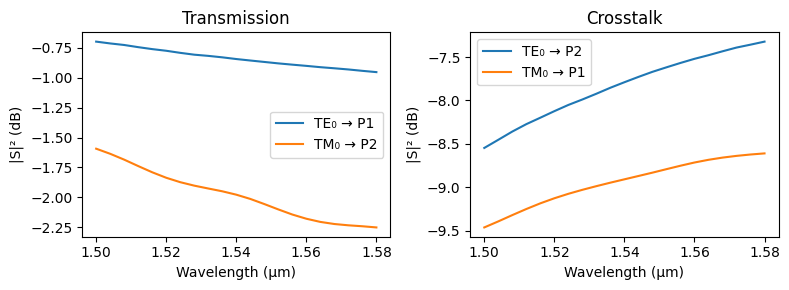

In [8]:
_, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

ax[0].plot(wavelengths, 20 * np.log10(np.abs(s_test[f"P0@0", f"P1@0"])), label=f"TE₀ → P1")
ax[0].plot(wavelengths, 20 * np.log10(np.abs(s_test[f"P0@1", f"P2@0"])), label=f"TM₀ → P2")
ax[0].set(title="Transmission", xlabel="Wavelength (μm)", ylabel="|S|² (dB)")

ax[1].plot(wavelengths, 20 * np.log10(np.abs(s_test[f"P0@0", f"P2@0"])), label=f"TE₀ → P2")
ax[1].plot(wavelengths, 20 * np.log10(np.abs(s_test[f"P0@1", f"P1@0"])), label=f"TM₀ → P1")
ax[1].set(title="Crosstalk", xlabel="Wavelength (μm)", ylabel="|S|² (dB)")

for a in ax:
    a.legend()

As expected, since we are using a different technology stack with different etch depths and shorter functional sections, we see cross coupling of TE and TM modes into both waveguides.
Ideally, we want full transmission of TE light from port P0 to P1, and full transmission of TM light from P0 to P2.
This way, the 2 orthogonal polarizations are spatially separated (and converted to TE in teh case of TM) using this PSR.

The insertion loss is not ideal for either input, and the cross-coupling is higher than we would like.
Typically, we are after at least 20 dB isolation for the orthogonal polarization at the output channels.

The complete device has many parameters that we can improve upon, but it is a good idea to subdivide the component in 2 separate designs that can be independently optimized using smaller simulations: the polarization rotator and the splitter.

## Polarization Rotator Optimization

The rotator is the first part of the PSR.
We create a parametric component for the rotator only so that we can optimize it independently of the splitter.

The port connecting both sub-components is a slab section with with defined as a parameter to be optimized (`rotator_width`).
Therefore, in order to define the intermediary port we will need a custom [port specification](../guides/Ports.ipynb), which is created within the function.

In [9]:
@pf.parametric_component
def create_rotator(*, rotator_length=70, rotator_width=1.1, taper_width=0.1, model_kwargs={}):
    component = pf.Component()

    core_width = 0.5

    # Added margin to avoid the second port touching the input taper
    port_margin = core_width

    input_taper = pf.Path((0, 0), core_width).segment((rotator_length, 0), taper_width)
    slab = (
        pf.Path((0, 0), core_width)
        .segment((rotator_length, 0), rotator_width)
        .segment((port_margin, 0), relative=True)
    )
    component.add("Si", input_taper, "Si slab", slab)

    slab_spec = pf.PortSpec(
        description="Slab 1550 nm",
        width=3.5,
        num_modes=2,
        target_neff=3.5,
        limits=(-1, 1.22),
        path_profiles=[(rotator_width, 0, "Si slab")],
    )

    component.add_port(
        [
            pf.Port((0, 0), 0, "TM_1550_500"),
            pf.Port((rotator_length + port_margin, 0), 180, slab_spec),
        ]
    )

    component.add_model(pf.Tidy3DModel(**model_kwargs), "Tidy3D")
    return component


create_rotator()

We must be careful when optimizing `rotator_width` to make sure slab it defines supports the 2 TE modes we need.
It is easy to solve for the modes of a port within PhotonForge, so we can use this facility to choose the optimization boundaries for this parameter.

For example, if we set it to 0.9 we still have the 2 TE modes well-confined even at the longer wavelength:

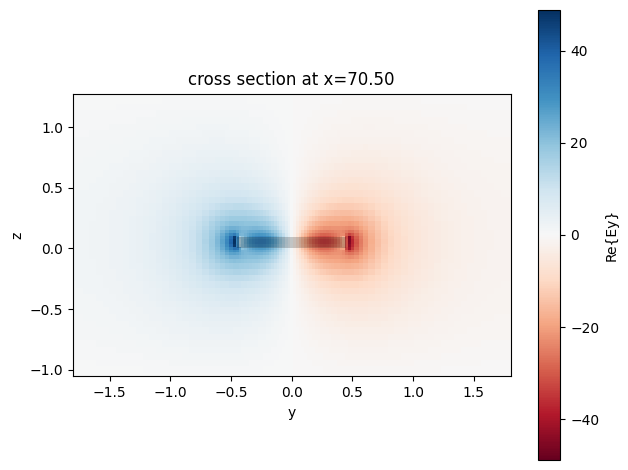

In [10]:
rotator = create_rotator(rotator_width=0.9)
mode_solver = rotator.ports["P1"].to_tidy3d_mode_solver(pf.C_0 / wavelengths[-1:])
_ = mode_solver.plot_field("Ey", mode_index=1, robust=False)

### Monte-Carlo Analysis

We can run a [Monte Carlo](../monte_carlo.rst) analysis to quickly sample our parameter space and identify the rotator parameters that would result in low loss for both polarizations.
Because this component has minimal losses, decreasing the `shutoff` parameter is required to guarantee passive S matrices.

In [11]:
model_kwargs = {"shutoff": 1e-6, "verbose": False}

rot_vars, rot_results = pf.monte_carlo.s_matrix(
    create_rotator(model_kwargs=model_kwargs),
    pf.C_0 / wavelengths,
    ("rotator_length", "component", {"value_range": (10, 30)}),
    ("rotator_width", "component", {"value_range": (0.9, 1.2)}),
    random_samples=12,
    corner_samples=4,
    random_seed=0,
    model_kwargs={"inputs": ["P0"]},
)

Sample 2 of 16...

Sample 4 of 16...

Sample 6 of 16...

Sample 8 of 16...

Sample 10 of 16...

Sample 12 of 16...

Sample 14 of 16...

Sample 16 of 16...

 done!


We build a figure of merit table to help us select the best variation among the tests:

[[ 0.9        10.          0.35126717]
 [ 1.2        10.          0.93737503]
 [ 0.9        30.          0.66532324]
 [ 1.2        30.          0.97414678]
 [ 1.06787973 28.09657603  0.95845028]
 [ 1.03559137 20.64063618  0.93862559]
 [ 1.02229433 10.45442716  0.67084069]
 [ 0.99479313 22.46662862  0.90164212]
 [ 1.14813992 28.89566027  0.96821991]
 [ 0.90050546 14.92859192  0.55413803]
 [ 1.0967503  19.12268007  0.97040605]
 [ 1.11153698 24.46479922  0.96171658]
 [ 1.19099803 17.56228871  0.9680172 ]
 [ 0.96304621 25.78933404  0.89621831]
 [ 1.16935584 12.02758393  0.92743762]
 [ 0.92838045 15.54023501  0.66168609]]


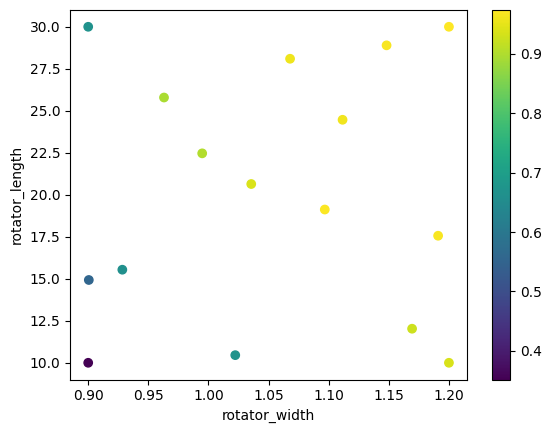

In [12]:
fom = np.array(
    [
        (*v, min(np.abs(s["P0@0", "P1@0"]).min(), np.abs(s["P0@1", "P1@1"]).min()) ** 2)
        for *v, s in rot_results
    ]
)
print(fom)

plt.scatter(fom[:, 0], fom[:, 1], c=fom[:, -1])
plt.xlabel(rot_vars[0].name)
plt.ylabel(rot_vars[1].name)
_ = plt.colorbar()

We can use the best parameter as a starting point for any local optimization method, similarly to what is done in the [crossing example](Waveguide_Crossing.ipynb).

In this case, if we look at the result around this point, we will note that the curves are already acceptable for our use case, so we will skip the local optimization step.

Best options: rotator_width=1.2, rotator_length=30.0


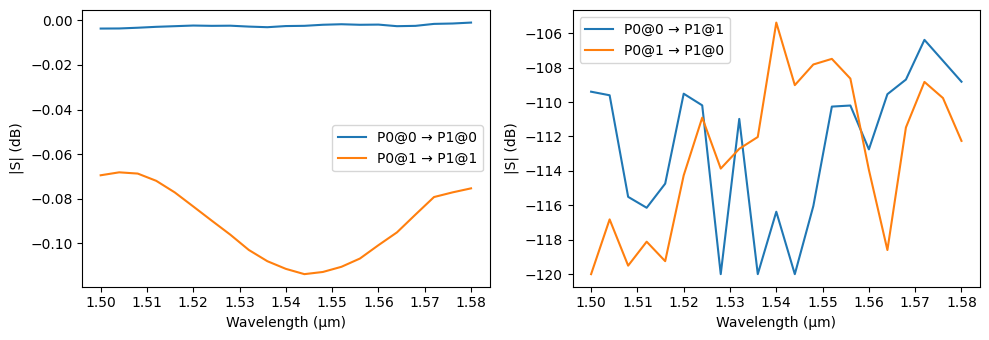

In [13]:
best_index = np.argmax(fom[:, -1])
rotator_width_opt, rotator_length_opt, s_matrix = rot_results[best_index]

pf.plot_s_matrix(s_matrix, y="dB", output_ports=["P1"])
print(f"Best options: rotator_width={rotator_width_opt}, rotator_length={rotator_length_opt}")

## Asymmetric Coupler Optimization

Similarly to what we have done to the rotator, we can now optimize the asymmetric coupler that forms the splitter section of our PSR.

In [14]:
@pf.parametric_component
def create_splitter(
    *,
    mid_taper_length=5,
    splitter_length=100,
    taper_length=10,
    rotator_width=1.1,
    taper_width=0.1,
    coupler_width1=0.95,
    coupler_width2=0.65,
    splitter_width1=0.2,
    Wo=5,
    gap=0.15,
    s_factor=6,
    model_kwargs={}
):
    component = pf.Component()

    s_bend_length = s_factor * output_separation
    splitter_width2 = coupler_width1 + splitter_width1 - coupler_width2
    if splitter_width2 <= 0:
        raise ValueError("Invalid input")

    p1 = (mid_taper_length + splitter_length + s_bend_length + taper_length, -output_separation)
    p2 = (
        mid_taper_length + splitter_length + s_bend_length + taper_length,
        gap + 0.5 * (coupler_width2 + splitter_width2),
    )
    tapers = [
        pf.Path(p1, core_width).segment((-taper_length, 0), taper_width, relative=True),
        pf.Path(p2, core_width).segment((-taper_length, 0), taper_width, relative=True),
    ]

    main_path = (
        pf.Path((0, 0), rotator_width)
        .segment((mid_taper_length, 0), coupler_width1, relative=True)
        .segment((splitter_length, 0), coupler_width2, relative=True)
        .s_bend((s_bend_length, -output_separation), euler_fraction=0.5, relative=True)
        .segment((taper_length, 0), core_width, relative=True)
    )

    coupled_path = (
        pf.Path(p2, core_width)
        .segment((-taper_length, 0), splitter_width2, relative=True)
        .segment((-s_bend_length, 0), relative=True)
        .segment((-splitter_length, 0), splitter_width1, relative=True)
    )
    component.add("Si", *tapers, "Si slab", main_path, coupled_path)

    slab_spec = pf.PortSpec(
        description="Slab 1550 nm",
        width=3.5,
        num_modes=2,
        target_neff=3.5,
        limits=(-1, 1.22),
        path_profiles=[(rotator_width, 0, "Si slab")],
    )

    component.add_port(
        [
            pf.Port((0, 0), 0, slab_spec),
            pf.Port(p1, 180, "TE_1550_500"),
            pf.Port(p2, 180, "TE_1550_500"),
        ]
    )

    component.add_model(pf.Tidy3DModel(**model_kwargs), "Tidy3D")
    return component


create_splitter()

The splitter has a few more parameters than the rotator, so the parameter space exploration must contain more samples to be effective.
However, because we have a reasonable starting point, we will use the Nelder-Mead optimization algorithm to look for a local optimum.

First, we have to define our objective function.
In this case we use 2 metrics: minimization of the insertion loss and the cross-coupling.
It is important to include both because it is possible to have low insertion loss with a cross-coupling well above the ideal target of -20 dB.

In [15]:
cross_target = 0.1
model_kwargs = {"grid_spec": 15, "verbose": False}


def splitter_objective(args):
    splitter = create_splitter(
        rotator_width=rotator_width_opt,
        mid_taper_length=args[0],
        splitter_length=args[1],
        coupler_width1=args[2],
        coupler_width2=args[3],
        model_kwargs=model_kwargs,
    )
    s = splitter.s_matrix(pf.C_0 / wavelengths, model_kwargs={"inputs": ["P0"]})

    min_transmission = min(np.abs(s["P0@0", "P1@0"]).min(), np.abs(s["P0@1", "P2@0"]).min())
    max_cross_coupling = max(np.abs(s["P0@1", "P1@0"]).max(), np.abs(s["P0@0", "P2@0"]).max())

    result = -min_transmission + 2 * max(0, max_cross_coupling - cross_target)

    # We can print the current evaluation result to keep track of the optimization process
    print(args, "→", (min_transmission, max_cross_coupling, result), flush=True)

    return result

We will try to make the splitter more compact than the original by starting with less than half the original `splitter_length`.
We also limit the number of evaluations of the objective function to 20.
If, at the end of the run, we're not satisfied with the result, we can restart with a higher limit and the cached results will be used for the first 20 iterations.

In [16]:
opt_result = scipy.optimize.minimize(
    splitter_objective,
    (5, 40, 0.95, 0.65),
    method="Nelder-Mead",
    bounds=[(4, 10), (10, 70), (0.9, 1.3), (0.5, 0.8)],
    options={"maxfev": 20, "fatol": 0.005, "xatol": 0.005},
)
opt_result

Starting...


Progress: 100% 
[ 5.   40.    0.95  0.65] → (0.8624885718154625, 0.47421913682450745, -0.11405029816644752)


Starting...


Progress: 100% 


[ 5.25 40.    0.95  0.65] → (0.8624927871644437, 0.4743823750679398, -0.11372803702856404)


Starting...


Progress: 100% 
[ 5.   42.    0.95  0.65] → (0.8728436115697783, 0.4517789917754583, -0.1692856280188616)


Starting...


Progress: 100% 


[ 5.     40.      0.9975  0.65  ] → (0.8672144413297505, 0.4709240691465105, -0.12536630303672935)


Starting...


Progress: 100% 
[ 5.     40.      0.95    0.6825] → (0.9385369247940155, 0.2816245370364004, -0.5752878507212147)


Starting...


Progress: 100% 


[ 4.75    41.       0.97375  0.66625] → (0.8962850747828944, 0.40958858990893376, -0.27710789496502686)


Starting...


Progress: 100% 


[ 4.875    41.5       0.985625  0.674375] → (0.9168008161486204, 0.35941575129836717, -0.39796931355188614)


Starting...


Progress: 100% 


[ 4.8125    42.25       0.9321875  0.6865625] → (0.9386832037505058, 0.2630121273654542, -0.6126589490195975)


Starting...


Progress: 100% 


[ 4.71875    43.375       0.9         0.70484375] → (0.9403270453157744, 0.20762423581663508, -0.7250785736825043)


Starting...


Progress: 100% 
[ 4.671875   40.9375      0.9546875   0.71398437] → (0.9483452137948429, 0.24646452065919142, -0.6554161724764601)


Starting...


Progress: 100% 
[ 4.8828125  41.90625     0.92140625  0.72160156] → (0.9472291765576873, 0.1869987930730184, -0.7732315904116506)


Starting...


Progress: 100% 
[ 4.94921875 42.359375    0.9         0.74927734] → (0.9134527778772097, 0.13460603011903893, -0.8442407176391318)


Starting...


Progress: 100% 


[ 4.79492188 41.8359375   0.9         0.75092773] → (0.9124474678575129, 0.12946335130338107, -0.8535207652507507)


Starting...


Progress: 100% 


[ 4.75488281 42.00390625  0.9         0.7892041 ] → (0.803240184248592, 0.10278028341217717, -0.7976796174242377)


Starting...


Progress: 100% 


[ 4.56738281 44.25390625  0.9         0.7770166 ] → (0.8504794423833091, 0.11198382484580928, -0.8265117926916905)


Starting...


Progress: 100% 
[ 4.84326172 44.97460938  0.9         0.77704834] → (0.8526651529709302, 0.09708464618734167, -0.8526651529709302)


Starting...


Progress: 100% 
[ 4.85864258 43.33691406  0.9         0.8       ] → (0.7666744756009967, 0.11933909087225378, -0.7279962938564891)


Starting...


Progress: 100% 


[ 4.82366943 43.34643555  0.9         0.79292938] → (0.7937577219293579, 0.11423014734199595, -0.765297427245366)


Starting...


Progress: 100% 


[ 4.75372314 43.36547852  0.9         0.73420563] → (0.9322035933143388, 0.1419759593787618, -0.8482516745568152)


Starting...


Progress: 100% 


[ 5.10317993 42.01379395  0.9         0.72871292] → (0.933110245515925, 0.1629343060337456, -0.8072416334484338)


       message: Maximum number of function evaluations has been exceeded.
       success: False
        status: 1
           fun: -0.8535207652507507
             x: [ 4.795e+00  4.184e+01  9.000e-01  7.509e-01]
           nit: 11
          nfev: 20
 final_simplex: (array([[ 4.795e+00,  4.184e+01,  9.000e-01,  7.509e-01],
                       [ 4.843e+00,  4.497e+01,  9.000e-01,  7.770e-01],
                       ...,
                       [ 4.949e+00,  4.236e+01,  9.000e-01,  7.493e-01],
                       [ 4.567e+00,  4.425e+01,  9.000e-01,  7.770e-01]]), array([-8.535e-01, -8.527e-01, -8.483e-01, -8.442e-01,
                       -8.265e-01]))

We can see from the log above that the best solution almost reached -20 dB (0.1 in linear magnitude scale).
We can check the splitter very easily:

Starting...


Progress: 100% 


Best options: mid_taper_length=4.794921875, splitter_length=41.8359375, coupler_width1=0.9, coupler_width2=0.7509277343750002


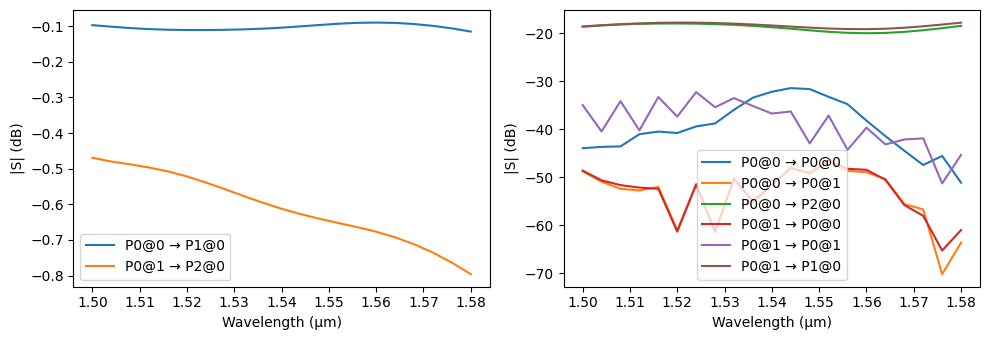

In [17]:
model_kwargs = {"grid_spec": 15, "verbose": False}

mid_taper_length_opt = opt_result.x[0]
splitter_length_opt = opt_result.x[1]
coupler_width1_opt = opt_result.x[2]
coupler_width2_opt = opt_result.x[3]

splitter = create_splitter(
    rotator_width=rotator_width_opt,
    mid_taper_length=mid_taper_length_opt,
    splitter_length=splitter_length_opt,
    coupler_width1=coupler_width1_opt,
    coupler_width2=coupler_width2_opt,
    model_kwargs=model_kwargs,
)

s = splitter.s_matrix(pf.C_0 / wavelengths, model_kwargs={"inputs": ["P0"]})
pf.plot_s_matrix(s, y="dB")
print(
    f"Best options: mid_taper_length={mid_taper_length_opt}, splitter_length={splitter_length_opt}, coupler_width1={coupler_width1_opt}, coupler_width2={coupler_width2_opt}"
)

## Complete PSR

Finally, we recreate the full PSR using the optimized parameters from each section.
We add an extra monitor to this version so that we can inspect the field distributions from the FDTD simulations.

In [18]:
monitor = td.FieldMonitor(
    name="field_xy",
    center=(0, 0, 0.05),
    size=(td.inf, td.inf, 0),
    freqs=[pf.C_0 / wavelengths[wavelengths.size // 2]],
)

model_kwargs = {"grid_spec": 15, "shutoff": 1e-6, "monitors": [monitor]}

psr_optimized = create_psr(
    rotator_length=rotator_length_opt,
    rotator_width=rotator_width_opt,
    mid_taper_length=mid_taper_length_opt,
    splitter_length=splitter_length_opt,
    coupler_width1=coupler_width1_opt,
    coupler_width2=coupler_width2_opt,
    model_kwargs=model_kwargs,
)
psr_optimized

Now we can calculate the full PSR S parameters.
Because the splitter section only approximately reached -20 dB cross-polarization, we expect a slightly worse figure when coupling to the rotator section, but good enough for our example.

In [19]:
s_opt = psr_optimized.s_matrix(td.C_0 / wavelengths, model_kwargs={"inputs": ["P0"]})

Starting...
Loading cached simulation from .tidy3d/pf_cache/G3T/fdtd_info-YIEQNZTVXOZ3247T2IIF6BM377EZHR4IC5S3GVIWUYT77VNH2BBQ.json.
Loading cached simulation from .tidy3d/pf_cache/G3T/fdtd_info-AAV5WRJAILDIROJOQUKGP73FQQSVWRPALZ4O2DA4ZPTJQZJQF7EA.json.
Progress: 100% 


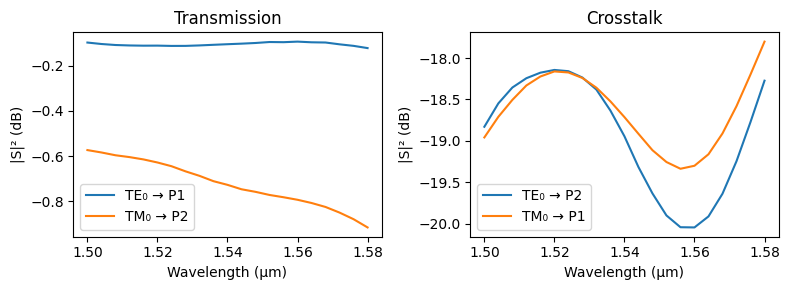

In [20]:
_, ax = plt.subplots(1, 2, figsize=(8, 3), tight_layout=True)

ax[0].plot(wavelengths, 20 * np.log10(np.abs(s_opt[f"P0@0", f"P1@0"])), label=f"TE₀ → P1")
ax[0].plot(wavelengths, 20 * np.log10(np.abs(s_opt[f"P0@1", f"P2@0"])), label=f"TM₀ → P2")
ax[0].set(title="Transmission", xlabel="Wavelength (μm)", ylabel="|S|² (dB)")

ax[1].plot(wavelengths, 20 * np.log10(np.abs(s_opt[f"P0@0", f"P2@0"])), label=f"TE₀ → P2")
ax[1].plot(wavelengths, 20 * np.log10(np.abs(s_opt[f"P0@1", f"P1@0"])), label=f"TM₀ → P1")
ax[1].set(title="Crosstalk", xlabel="Wavelength (μm)", ylabel="|S|² (dB)")

for a in ax:
    a.legend()

In this optimized design, we see that the insertion loss for TE mode (TM mode) is less than 0.2 dB (1.3 dB).
As expected, the crosstalk between the 2 different polarizations is slightly above -20 dB.

Finally, let's look at the field distribution in the xy-plane for both inputs.
We can easily load the batch data from out simulations:

In [21]:
sim_data = psr_optimized.models["Tidy3D"].batch_data_for(psr_optimized)
sim_data.task_ids

{'P0@0': 'fdve-989982fc-6f77-4a75-8b8a-5775410200b1',
 'P0@1': 'fdve-6e639525-efa2-4259-b162-e47fad9b8388'}

### TE input

20:29:58 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

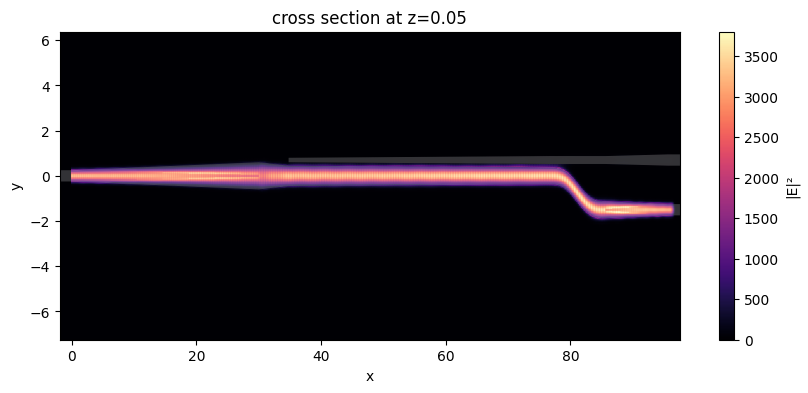

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sim_data["P0@0"].plot_field("field_xy", "E", val="abs^2", robust=False, ax=ax)
ax.set_aspect("auto")

### TM input

20:30:00 -03 WARNING: Warning messages were found in the solver log. For more   
             information, check 'SimulationData.log' or use                     
             'web.download_log(task_id)'.                                       

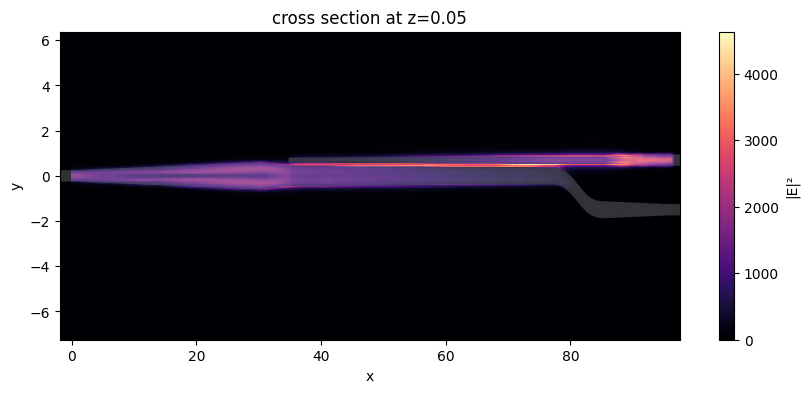

In [23]:
fig, ax = plt.subplots(1, 1, figsize=(10, 4))
sim_data["P0@1"].plot_field("field_xy", "E", val="abs^2", robust=False, ax=ax)
ax.set_aspect("auto")

It is, of course, still possible to further optimize this PSR by changing other geometry parameters, such as the coupling gap or taper tips, as well as performing a local optimization for the rotator and exploring longer lengths for the splitter.